# Set-up

## Imports

In [21]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# ALE
# from alibi.explainers import ALE, plot_ale

## Parameters

In [26]:
scope = 'BID'
input_path = f'/Users/guillaume/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Share/asm_forecast/ML_dataset_{scope}.pkl'

train_years = [2021]
test_years = [2022]

subsample_frac = None

target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'SolarAngle',
    'DeclAngle',
    'PVnew',
    'PriceDiff',
]

features = other_features + features_to_encode

In [27]:
province_codes = {
    'Milano': 'MI',
    'Belluno': 'BL',
    'Bologna': 'BO',
    'Verona': 'VR',
    'Bolzano': 'BZ',
    'Bergamo': 'BG',
    'Cuneo': 'CN',
    'Vicenza': 'VI',
    'Pordenone': 'PN',
    'Lodi': 'LO',
    'Brescia': 'BS',
    'Treviso': 'TV',
    'Venezia': 'VE',
    'Sondrio': 'SO',
    'Verbano-Cusio-Ossola': 'VB',
    'Como': 'CO',
    'Aosta': 'AO',
    'Torino': 'TO',
    'Trento': 'TN',
    'Gorizia': 'GO',
    'Vercelli': 'VC',
    'Novara': 'NO',
    'Pavia': 'PV',
    'Mantova': 'MN',
    'Ravenna': 'RA',
    'Varese': 'VA',
    'Ferrara': 'FE',
    'Udine': 'UD',
    'Savona': 'SV',
    'Piacenza': 'PC',
    'La Spezia': 'SP',
    'Genova': 'GE',
    'Reggio Emilia': 'RE'
}

# Main

## Load data

In [28]:
input_df = pd.read_pickle(input_path)
print("{:,}".format(len(input_df)))
input_df.head(3)

2,177,292


,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty
2018010118UP_ALTOADDA_1_BID,18,20180101,2018,UP_ALTOADDA_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.349,False,0.0,22.0
2018010119UP_ALTOADDA_1_BID,19,20180101,2018,UP_ALTOADDA_1,BID,1.249924,0.598779,-1.772487,-0.866850,0.891173,...,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.329,False,0.0,22.0
2018010120UP_ALTOADDA_1_BID,20,20180101,2018,UP_ALTOADDA_1,BID,0.243493,0.768175,-1.758348,-0.872364,-0.334594,...,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.324,False,0.0,22.0


In [29]:
# Subsample
if subsample_frac is not None:
    print(f'Subsampled {100*subsample_frac:.0f}% rows from the input dataset')
    df = input_df.sample(frac=subsample_frac)
else:
    df = input_df.copy()

print('Input dataset is composed of {:,} observations'.format(len(input_df)))
print('{:.1%} bids accepted in the input dataset\n'.format(input_df[target].sum() / len(input_df)))

train_df = df[df.year.isin(train_years)]
print('Training data is composed of {:,} observations and correspond to years {}'.format(len(train_df), ' '.join([str(year) for year in train_years])))
print('{:.1%} bids accepted in the training data\n'.format(train_df[target].sum() / len(train_df)))

test_df = df[df.year.isin(test_years)]
# test_df.dropna(subset=['PriceDiff'], inplace=True) # HOTFIX
# test_df = test_df[~(test_df == np.inf).any(axis=1)] # HOTFIX
print('Test data is composed of {:,} observations and correspond to years {}'.format(len(test_df), ' '.join([str(year) for year in test_years])))
print('{:.1%} bids accepted in the test data'.format(test_df[target].sum() / len(test_df)))

Input dataset is composed of 2,177,292 observations
15.9% bids accepted in the input dataset

Training data is composed of 394,157 observations and correspond to years 2021
19.4% bids accepted in the training data

Test data is composed of 333,090 observations and correspond to years 2022
18.1% bids accepted in the test data


In [30]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False
)

X_train = feature_transformer.fit_transform(train_df[features])
y_train = train_df[target]

X_test = feature_transformer.transform(test_df[features])
y_test = test_df[target]

print('Input features are:')
print(feature_transformer.feature_names_in_)

Input features are:
['hour' 'SC_PC1' 'SC_PC2' 'IN_PC1' 'IN_PC2' 'CT_PC1' 'CT_PC2' 'PurchMGP'
 'SellMGP' 'SolarAngle' 'DeclAngle' 'PVnew' 'PriceDiff' 'MargTech'
 'WorkDay' 'Prov' 'Tech']


## Load model

In [31]:
model_path = '{}/model_dumps/model_trained_{}_{}.joblib'.format(scope, scope, '_'.join([str(year) for year in train_years]))
clf = joblib.load(model_path)
print(f'Model {model_path} loaded\n')

Model BID/model_dumps/model_trained_BID_2021.joblib loaded



## Permutation Feature Importance

In [32]:
clf_pipeline = make_pipeline(feature_transformer, clf)

In [24]:
train_result = permutation_importance(
    clf_pipeline, train_df[features], y_train, scoring='average_precision', random_state=42, n_jobs=-1
)

In [33]:

test_result = permutation_importance(
    clf_pipeline, test_df[features], y_test, scoring='average_precision', random_state=42, n_jobs=-1
)

In [34]:
sorted_importances_idx = test_result.importances_mean.argsort()

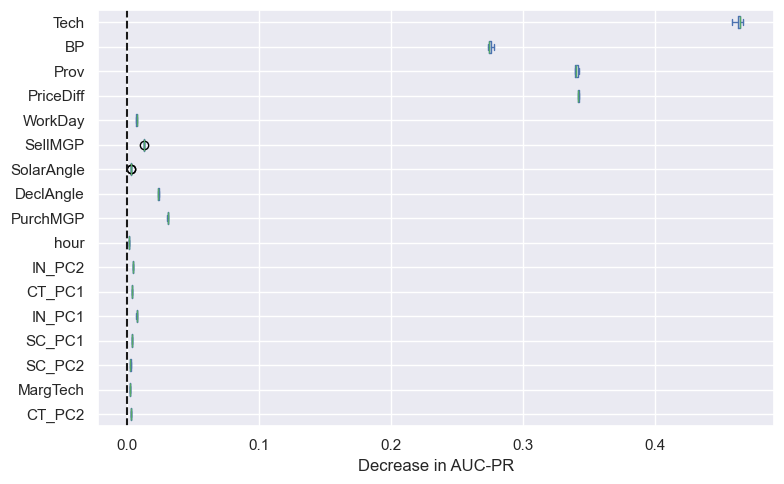

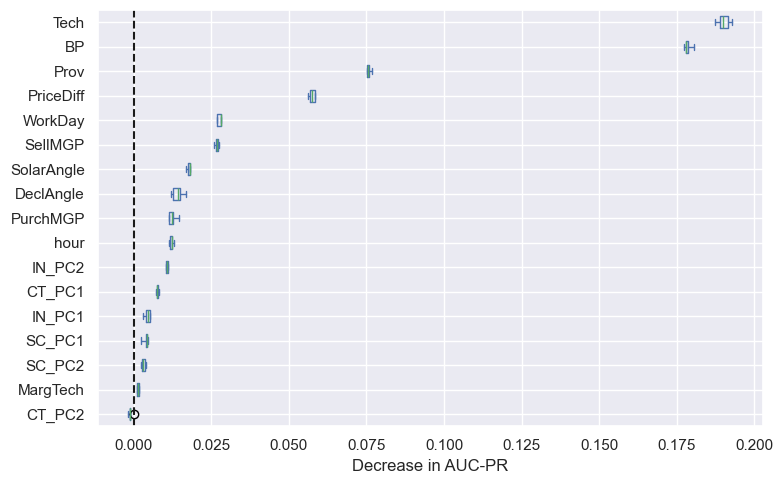

In [27]:
columns = train_df[features].columns[sorted_importances_idx]
columns = ['BP' if col == 'PVnew' else col for col in columns]

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=columns,
)
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=columns,
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
# for name, importances in zip(["train"], [train_importances]):
    ax = importances.plot.box(vert=False, whis=10, figsize=(8,5))
    # ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in AUC-PR")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

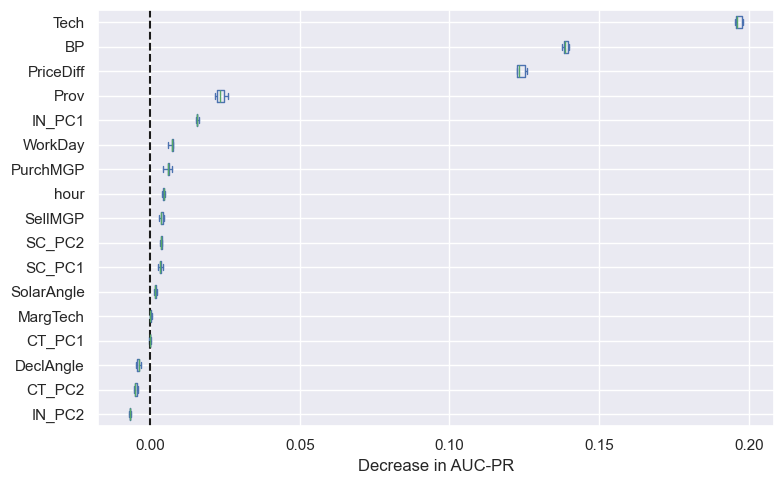

In [35]:
columns = train_df[features].columns[sorted_importances_idx]
columns = ['BP' if col == 'PVnew' else col for col in columns]
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=columns,
)
ax = test_importances.plot.box(vert=False, whis=10, figsize=(8,5))
# ax.set_title(f"Permutation Importances ({name} set)")
ax.set_xlabel("Decrease in AUC-PR")
ax.axvline(x=0, color="k", linestyle="--")
ax.figure.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/pfi_{scope}_test.png')

In [14]:
test_importances

,CT_PC2,MargTech,SC_PC2,SC_PC1,IN_PC1,CT_PC1,IN_PC2,hour,PurchMGP,DeclAngle,SolarAngle,SellMGP,WorkDay,PriceDiff,Prov,BP,Tech
0,-0.001742,0.001152,0.003486,0.004451,0.004543,0.008038,0.010452,0.012257,0.014549,0.016862,0.018089,0.027458,0.028045,0.058334,0.075166,0.178037,0.188922
1,-0.001168,0.001835,0.002365,0.004636,0.002927,0.007730,0.010912,0.011426,0.011376,0.014886,0.018000,0.026562,0.026859,0.056245,0.075871,0.180508,0.187341
2,0.000044,0.001333,0.002669,0.002284,0.005154,0.007083,0.010471,0.012852,0.011499,0.012689,0.018105,0.027249,0.026899,0.058336,0.076719,0.177282,0.192904
3,-0.001178,0.001818,0.003939,0.004246,0.004022,0.007529,0.011008,0.012400,0.012639,0.011949,0.017492,0.025823,0.028023,0.057581,0.075101,0.177879,0.189924
4,-0.001228,0.001170,0.002946,0.004006,0.005337,0.007528,0.010581,0.011579,0.012358,0.014425,0.016862,0.026832,0.028053,0.056927,0.075595,0.178460,0.191426


## Partial Dependence Plot

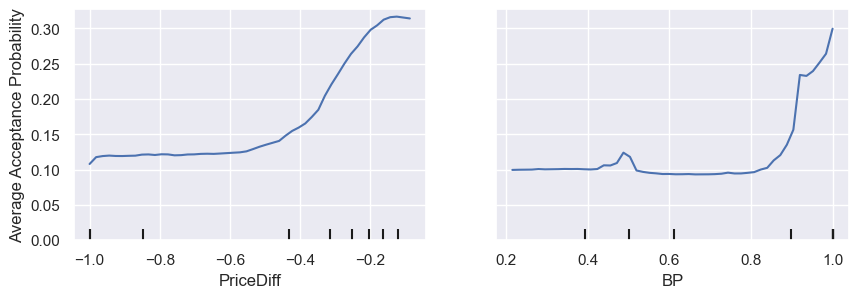

In [36]:
disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['PriceDiff', 'PVnew'],
    # categorical_features = np.array([col in features_to_encode for col in test_df[features].columns.to_list()]),
    n_jobs = -1,
    kind = ['average', 'average'],
    subsample = 100,
    grid_resolution = 50,  # Optional: controls the resolution of the grid for plotting
    n_cols = 2,  # This arranges the subplots in two columns
)

# xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
# disp.figure_.axes[1].set_xticklabels(xtick_names)

# Change the x-axis labels for each subplot
x_labels = ['PriceDiff', 'BP']
# # Change the y-axis labels for each subplot
# y_labels = ['Average Acceptance Probability', 'Average Acceptance Probability']

# Iterate over each subplot and set the x-axis label
for ax, label in zip(disp.axes_.ravel(), x_labels):
    ax.set_xlabel(label)

disp.axes_[0,0].set_ylabel('Average Acceptance Probability')
disp.axes_[0,0].set_ylim(bottom=0)
disp.axes_[0,1].set_ylim(bottom=0)

# # Set the y-axis limits and labels
# for ax, x_label, y_label in zip(disp.axes_.ravel(), x_labels, y_labels):
#     ax.set_xlabel(x_label)
#     ax.set_ylabel(y_label)
#     ax.set_ylim(bottom=0)  # Set the y-axis to start at 0

# # Force the subplots to share the same y-axis
# for ax in disp.axes_.ravel()[1:]:  # Skip the first subplot as it will be the reference
#     ax.get_shared_y_axes().join(disp.axes_.ravel()[0], ax)

disp.figure_.set_size_inches(10,3)
disp.figure_.subplots_adjust(hspace=0.1)
plt.savefig(f'../plots/{scope}/explainer/pdp_price_pv_{scope}_test.png')

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_60118/4114077146.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(tech_xtick_names)
/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_60118/4114077146.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(prov_xtick_names)


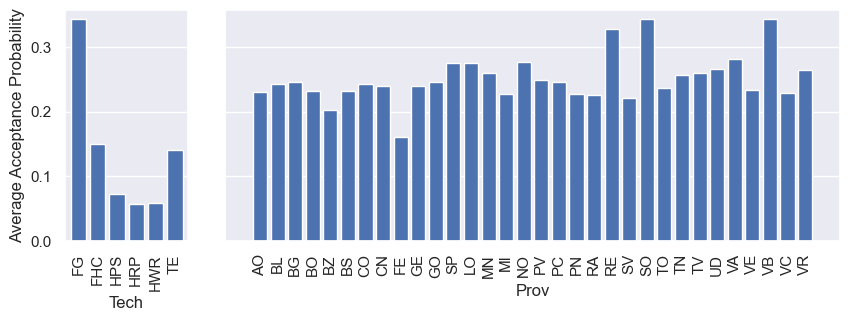

In [37]:
fig, axs = plt.subplots(1, 2, width_ratios=[1, 5], figsize=(10, 3), sharey=True)

disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['Tech', 'Prov'],
    categorical_features = ['Tech', 'Prov'],
    n_jobs = -1,
    kind = ['average', 'average'],
    subsample = 100,
    grid_resolution = 50,  # Optional: controls the resolution of the grid for plotting
    # n_cols = 2,  # This arranges the subplots in two columns
    ax = axs
)

tech_xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
prov_xtick_names = [province_codes[prov] for prov in sorted(province_codes.keys())]
axs[0].set_xticklabels(tech_xtick_names)
axs[1].set_xticklabels(prov_xtick_names)

# Change the x-axis labels for each subplot
x_labels = ['Tech', 'Prov']
# # Change the y-axis labels for each subplot
# y_labels = ['Average Acceptance Probability', 'Average Acceptance Probability']

# Iterate over each subplot and set the x-axis label
for ax, label in zip(axs, x_labels):
    ax.set_xlabel(label)
    ax.grid(False, axis='x')

axs[0].set_ylabel('Average Acceptance Probability')
axs[1].set_ylabel(None)
axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)

# # Set the y-axis limits and labels
# for ax, x_label, y_label in zip(disp.axes_.ravel(), x_labels, y_labels):
#     ax.set_xlabel(x_label)
#     ax.set_ylabel(y_label)
#     ax.set_ylim(bottom=0)  # Set the y-axis to start at 0

# # Force the subplots to share the same y-axis
# for ax in disp.axes_.ravel()[1:]:  # Skip the first subplot as it will be the reference
#     ax.get_shared_y_axes().join(disp.axes_.ravel()[0], ax)

plt.subplots_adjust(wspace=0.1, hspace=0)  # Adjust space between the plots
plt.savefig(f'../plots/{scope}/explainer/pdp_cat_{scope}_test.png', bbox_inches='tight')

## Accumulated Local Effects (ALE)

In [32]:
predictor = clf.predict_proba

# Features to explain should be numerical or ordinal
encoded_feature_names = list(feature_transformer.get_feature_names_out())
features_to_explain = [encoded_feature_names.index(feature) for feature in ['PVnew', 'PriceDiff', 'IN_PC1']]

ale = ALE(predictor, encoded_feature_names, target_names=['Rejected', 'Accepted'])
ale = ale.explain(X_test.toarray(), features=features_to_explain)

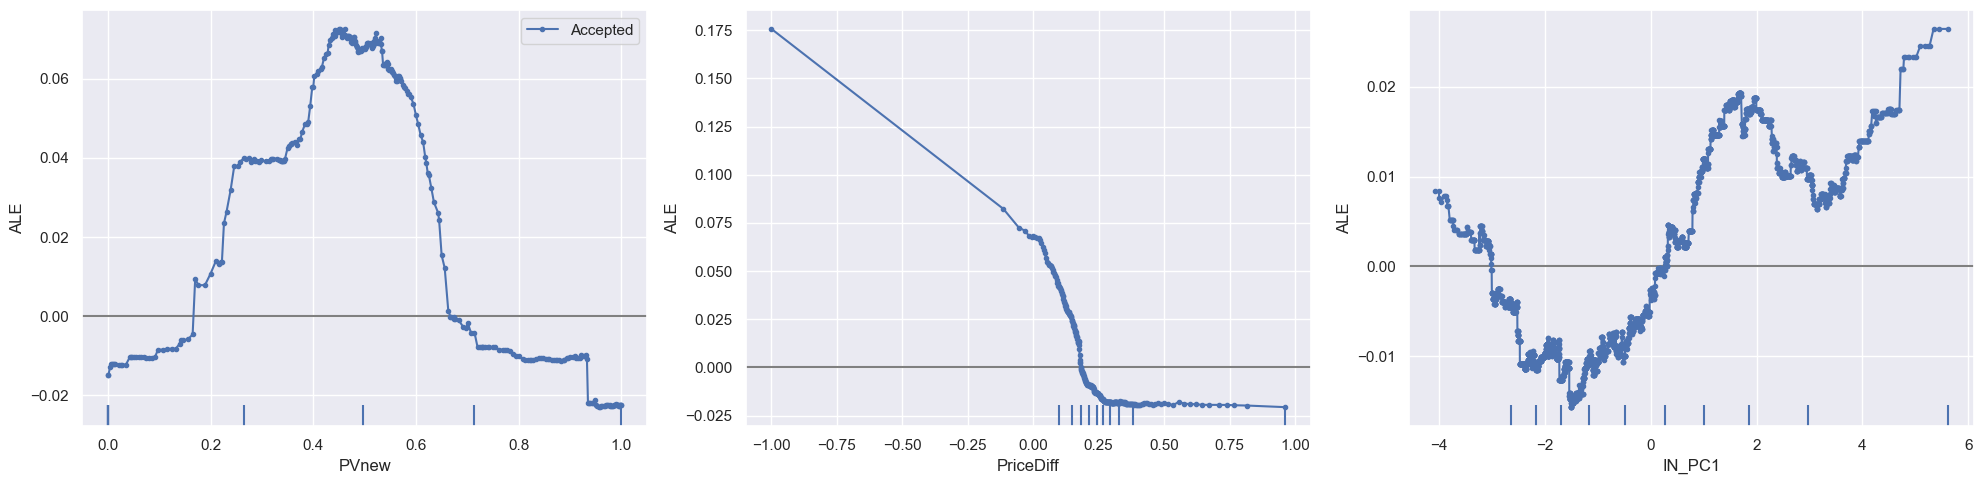

In [33]:
plot_ale(ale, targets=['Accepted'], n_cols=4, fig_kw={'figwidth': 20, 'figheight': 5}, sharey=None)
plt.tight_layout()

<HR>

# TESTS

In [27]:
df.Prov.unique()

array(['Milano', 'Belluno', 'Bologna', 'Verona', 'Bolzano', 'Bergamo',
       'Cuneo', 'Vicenza', 'Pordenone', 'Lodi', 'Brescia', 'Treviso',
       'Venezia', 'Sondrio', 'Verbano-Cusio-Ossola', 'Como', 'Aosta',
       'Torino', 'Trento', 'Gorizia', 'Vercelli', 'Novara', 'Pavia',
       'Mantova', 'Ravenna', 'Varese', 'Ferrara', 'Udine', 'Savona',
       'Piacenza', 'La Spezia', 'Genova', 'Reggio Emilia'], dtype=object)